## Image denoising

In [1]:
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np
from keras import backend as K
from keras.callbacks import TensorBoard

import warnings
warnings.filterwarnings("ignore")

2022-02-25 21:03:41.781705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 21:03:41.781838: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


####  Designing a Convolutional autoencoder for working on an image denoising problem

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_train.shape
)
x_test_noisy = x_test + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_test.shape
)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)


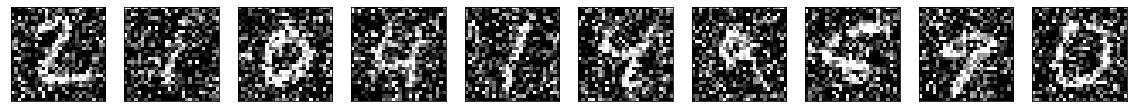

In [3]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### Now let's use another model with more filters per layer

In [4]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")


2022-02-25 21:04:20.327022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 21:04:20.330100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 21:04:20.331080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-25 21:04:20.331678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-25 21:04:20.332845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Open the terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

In the terminal:
- tensorboard --logdir=/tmp/autoencoder

In [5]:
autoencoder.fit(
    x_train_noisy,
    x_train,
    epochs=2,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[TensorBoard(log_dir="/tmp/tb", histogram_freq=0, write_graph=False)],
)


2022-02-25 21:04:21.700704: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-02-25 21:04:22.185138: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/2
469/469 [==============================] - 289s 609ms/step - loss: 0.1650 - val_loss: 0.1168
Epoch 2/2
469/469 [==============================] - 194s 414ms/step - loss: 0.1140 - val_loss: 0.1098


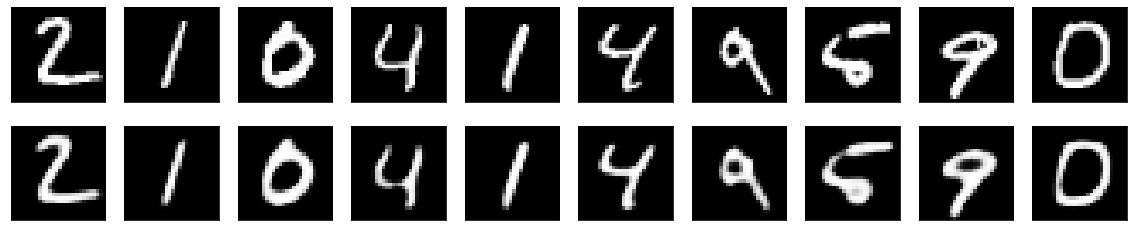

In [6]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()